In [1]:
import sys
sys.path.append('../')
from models import VGAE, LatentMLP 
from utils import BrainGraphDataset, project_root, get_data_labels
import torch
import torch.nn as nn
import torch.optim as optim
import os
from tqdm import tqdm
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root = project_root()

# instantiate the VGAE model
lr = 0.001
batch_size = 64

nf = 1
ef = 1
num_nodes = 100
hidden_dim = 128
latent_size = 8

criterion = nn.L1Loss(reduction='sum')
categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

annotations = 'annotations.csv'

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')

dataroot = 'fc_matrices/psilo_schaefer_before/'

dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='lz')

# Define the train, validation, and test ratios
train_ratio = 0.8
val_ratio = 0.2
test_ratio = 0.2

# Get the number of samples in the dataset
num_samples = len(dataset)

# Calculate the number of samples for each set
train_size = int(train_ratio * num_samples)
val_size = num_samples - train_size

torch.manual_seed(0)
# Split the dataset into train, validation, and test sets


import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

# Assuming you have your dataset defined as 'dataset'
num_folds = 5  # Specify the number of folds
batch_size = 8  # Specify your desired batch size
random_seed = 42  # Specify the random seed

# Create indices for k-fold cross-validation with seeded random number generator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Create empty lists to store train and validation loaders
train_loaders = []
val_loaders = []

for train_index, val_index in kf.split(dataset):
    # Split dataset into train and validation sets for the current fold
    train_set = torch.utils.data.Subset(dataset, train_index)
    val_set = torch.utils.data.Subset(dataset, val_index)

    # Define the dataloaders for the current fold
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Append the loaders to the respective lists
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)


num_epochs = 500

import json

# Dictionary to store training and validation curves
results = []
dropout_list = [0]
best_set = [0] * num_folds

for i, train_loader in enumerate(train_loaders):
    val_loader = val_loaders[i]
    for dropout in dropout_list:
        vgae = VGAE(1, 1, 100, 32, 8, device, dropout=0, l2_strength=0.001).to(device)
        # load the trained VGAE weights
        vgae.load_state_dict(torch.load(os.path.join(root, 'vgae_weights/vgae_nf_schaefer_32_8.pt'), map_location=device))
        # Convert the model to the device
        vgae.to(device)

        
        best_val_loss = float('inf')  # set to infinity to start
        best_model_state = None
        train_losses = []
        val_losses = []

        model = LatentMLP(64, 64, 1, dropout=dropout)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        src, dest = vgae.edge_index

        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            val_loss = 0.0

            # training
            model.train()
            for batch_idx, ((graph, lz, baseline_bdi), label) in enumerate(train_loader):
                graph = graph.to(device)  # move data to device
                lz = lz.to(device)
                label = label.to(device)
                optimizer.zero_grad()

                rcn_lz, rcn_edges, z, _, _ = vgae(lz, graph)
                graph = graph[:, src, dest]

                output_bdi = model(z.view(z.shape[0], -1), baseline_bdi)

                l1_loss, l2_loss = model.loss(output_bdi, label.view(output_bdi.shape))
                loss = l1_loss + l2_loss
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # validation
            model.eval()
            val_label = []
            val_output = []
            val_base = []
            with torch.no_grad():
                for batch_idx, ((graph, lz, baseline_bdi), label) in enumerate(val_loader):
                    graph = graph.to(device)  # move data to device
                    lz = lz.to(device)
                    label = label.to(device)

                    rcn_lz, rcn_edges, z, _, _ = vgae(lz, graph)
                    graph = graph[:, src, dest]

                    output_bdi = model(z.view(z.shape[0], -1), baseline_bdi)

                    val_label.extend(label)
                    val_output.extend(output_bdi)
                    val_base.extend(baseline_bdi)
                    
                    l1_loss, l2_loss = model.loss(output_bdi, label.view(output_bdi.shape))
                    loss = l1_loss + l2_loss
                    val_loss += loss.item()
            # append losses to lists
            train_losses.append(train_loss/len(train_set))
            val_losses.append(val_loss/len(val_set))

            # save the model if the validation loss is at its minimum
            if val_losses[-1] < best_val_loss:
                best_val_loss = val_losses[-1]

                best_model_state = (copy.deepcopy(vgae.state_dict()), copy.deepcopy(model.state_dict()))
                best_set[i] = (val_label, val_output, val_base)
            # print the losses
            with open('dropout_train.txt', 'a') as f:
                if (epoch + 1) % 20 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
                f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

        # save the best model for this configuration
        torch.save(best_model_state[1], os.path.join(root, f'mlp_weights/vgae_model_weight_schaefer_final.pt'))
        torch.save(best_model_state[0], os.path.join(root, f'mlp_weights/vgae_vgae_weight_schaefer_final.pt'))

#         # add the loss curves to the dictionary
#         loss_curves[f"dropout_{dropout}"] = {"train_loss": train_losses, "val_loss": val_losses}

    
#     # save the loss curves to a file
#     with open("loss_curves_mlp_vgae.json", "w") as f:
#         json.dump(loss_curves, f)

  4%|▍         | 20/500 [00:04<01:49,  4.38it/s]

Epoch 20/500 - Train Loss: 5.8957 - Val Loss: 12.1301



  8%|▊         | 40/500 [00:09<01:44,  4.38it/s]

Epoch 40/500 - Train Loss: 5.6920 - Val Loss: 11.7469



 12%|█▏        | 60/500 [00:13<01:39,  4.43it/s]

Epoch 60/500 - Train Loss: 5.0098 - Val Loss: 10.8113



 16%|█▌        | 80/500 [00:18<01:34,  4.43it/s]

Epoch 80/500 - Train Loss: 4.6969 - Val Loss: 10.3663



 20%|██        | 100/500 [00:22<01:30,  4.44it/s]

Epoch 100/500 - Train Loss: 4.2145 - Val Loss: 10.1006



 24%|██▍       | 120/500 [00:27<01:26,  4.39it/s]

Epoch 120/500 - Train Loss: 4.0227 - Val Loss: 8.7984



 28%|██▊       | 140/500 [00:31<01:20,  4.46it/s]

Epoch 140/500 - Train Loss: 3.0404 - Val Loss: 9.3409



 32%|███▏      | 160/500 [00:36<01:16,  4.46it/s]

Epoch 160/500 - Train Loss: 2.9008 - Val Loss: 9.2084



 36%|███▌      | 180/500 [00:40<01:11,  4.45it/s]

Epoch 180/500 - Train Loss: 2.8318 - Val Loss: 8.7512



 40%|████      | 200/500 [00:45<01:07,  4.44it/s]

Epoch 200/500 - Train Loss: 2.7437 - Val Loss: 8.8221



 44%|████▍     | 220/500 [00:49<01:02,  4.45it/s]

Epoch 220/500 - Train Loss: 2.4311 - Val Loss: 9.2824



 48%|████▊     | 240/500 [00:54<00:58,  4.47it/s]

Epoch 240/500 - Train Loss: 2.8804 - Val Loss: 9.0708



 52%|█████▏    | 260/500 [00:58<00:53,  4.48it/s]

Epoch 260/500 - Train Loss: 2.4367 - Val Loss: 9.3393



 56%|█████▌    | 280/500 [01:03<00:49,  4.46it/s]

Epoch 280/500 - Train Loss: 2.2765 - Val Loss: 10.2055



 60%|██████    | 300/500 [01:07<00:45,  4.44it/s]

Epoch 300/500 - Train Loss: 2.1251 - Val Loss: 9.7276



 64%|██████▍   | 320/500 [01:12<00:40,  4.46it/s]

Epoch 320/500 - Train Loss: 2.3449 - Val Loss: 9.9806



 68%|██████▊   | 340/500 [01:16<00:35,  4.47it/s]

Epoch 340/500 - Train Loss: 2.0386 - Val Loss: 11.6164



 72%|███████▏  | 360/500 [01:21<00:31,  4.43it/s]

Epoch 360/500 - Train Loss: 1.7980 - Val Loss: 10.8443



 76%|███████▌  | 380/500 [01:25<00:26,  4.48it/s]

Epoch 380/500 - Train Loss: 1.6358 - Val Loss: 11.9657



 80%|████████  | 400/500 [01:30<00:22,  4.47it/s]

Epoch 400/500 - Train Loss: 2.1985 - Val Loss: 11.2486



 84%|████████▍ | 420/500 [01:34<00:17,  4.48it/s]

Epoch 420/500 - Train Loss: 1.6080 - Val Loss: 11.9442



 88%|████████▊ | 440/500 [01:39<00:13,  4.47it/s]

Epoch 440/500 - Train Loss: 1.4253 - Val Loss: 11.5685



 92%|█████████▏| 460/500 [01:43<00:08,  4.47it/s]

Epoch 460/500 - Train Loss: 1.5155 - Val Loss: 11.9625



 96%|█████████▌| 480/500 [01:47<00:04,  4.46it/s]

Epoch 480/500 - Train Loss: 1.3716 - Val Loss: 12.3721



100%|██████████| 500/500 [01:52<00:00,  4.45it/s]


Epoch 500/500 - Train Loss: 2.0560 - Val Loss: 12.2221



  4%|▍         | 20/500 [00:04<01:47,  4.46it/s]

Epoch 20/500 - Train Loss: 6.9565 - Val Loss: 7.2745



  8%|▊         | 40/500 [00:08<01:42,  4.51it/s]

Epoch 40/500 - Train Loss: 5.6458 - Val Loss: 11.4063



 12%|█▏        | 60/500 [00:13<01:37,  4.51it/s]

Epoch 60/500 - Train Loss: 5.1263 - Val Loss: 11.3016



 16%|█▌        | 80/500 [00:17<01:33,  4.51it/s]

Epoch 80/500 - Train Loss: 4.7195 - Val Loss: 10.9753



 20%|██        | 100/500 [00:22<01:28,  4.52it/s]

Epoch 100/500 - Train Loss: 4.3126 - Val Loss: 10.4461



 24%|██▍       | 120/500 [00:26<01:23,  4.53it/s]

Epoch 120/500 - Train Loss: 4.4133 - Val Loss: 10.9112



 28%|██▊       | 140/500 [00:31<01:20,  4.47it/s]

Epoch 140/500 - Train Loss: 4.0199 - Val Loss: 12.5520



 32%|███▏      | 160/500 [00:35<01:15,  4.53it/s]

Epoch 160/500 - Train Loss: 3.8533 - Val Loss: 10.0750



 36%|███▌      | 180/500 [00:39<01:11,  4.50it/s]

Epoch 180/500 - Train Loss: 3.5323 - Val Loss: 10.2510



 40%|████      | 200/500 [00:44<01:06,  4.53it/s]

Epoch 200/500 - Train Loss: 4.0936 - Val Loss: 9.7263



 44%|████▍     | 220/500 [00:48<01:02,  4.46it/s]

Epoch 220/500 - Train Loss: 3.7710 - Val Loss: 9.7098



 48%|████▊     | 240/500 [00:53<00:58,  4.47it/s]

Epoch 240/500 - Train Loss: 3.4655 - Val Loss: 10.0791



 52%|█████▏    | 260/500 [00:57<00:53,  4.45it/s]

Epoch 260/500 - Train Loss: 3.1658 - Val Loss: 8.8206



 56%|█████▌    | 280/500 [01:02<00:49,  4.45it/s]

Epoch 280/500 - Train Loss: 3.1033 - Val Loss: 9.1504



 60%|██████    | 300/500 [01:06<00:44,  4.47it/s]

Epoch 300/500 - Train Loss: 3.4981 - Val Loss: 10.8327



 64%|██████▍   | 320/500 [01:11<00:40,  4.46it/s]

Epoch 320/500 - Train Loss: 3.1894 - Val Loss: 11.4576



 68%|██████▊   | 340/500 [01:15<00:35,  4.46it/s]

Epoch 340/500 - Train Loss: 3.3236 - Val Loss: 10.2667



 72%|███████▏  | 360/500 [01:20<00:31,  4.46it/s]

Epoch 360/500 - Train Loss: 2.6427 - Val Loss: 9.0285



 76%|███████▌  | 380/500 [01:24<00:26,  4.48it/s]

Epoch 380/500 - Train Loss: 3.0128 - Val Loss: 10.3162



 80%|████████  | 400/500 [01:29<00:22,  4.46it/s]

Epoch 400/500 - Train Loss: 2.6120 - Val Loss: 9.6557



 84%|████████▍ | 420/500 [01:33<00:17,  4.47it/s]

Epoch 420/500 - Train Loss: 2.8507 - Val Loss: 10.9221



 88%|████████▊ | 440/500 [01:38<00:13,  4.47it/s]

Epoch 440/500 - Train Loss: 2.8124 - Val Loss: 10.0644



 92%|█████████▏| 460/500 [01:42<00:08,  4.47it/s]

Epoch 460/500 - Train Loss: 2.7977 - Val Loss: 11.1228



 96%|█████████▌| 480/500 [01:47<00:04,  4.47it/s]

Epoch 480/500 - Train Loss: 2.7063 - Val Loss: 10.6784



100%|██████████| 500/500 [01:51<00:00,  4.48it/s]


Epoch 500/500 - Train Loss: 2.3618 - Val Loss: 11.5742



  4%|▍         | 20/500 [00:04<01:47,  4.47it/s]

Epoch 20/500 - Train Loss: 7.2932 - Val Loss: 6.0713



  8%|▊         | 40/500 [00:08<01:42,  4.50it/s]

Epoch 40/500 - Train Loss: 6.9155 - Val Loss: 5.9750



 12%|█▏        | 60/500 [00:13<01:38,  4.48it/s]

Epoch 60/500 - Train Loss: 6.0523 - Val Loss: 5.8381



 16%|█▌        | 80/500 [00:17<01:33,  4.49it/s]

Epoch 80/500 - Train Loss: 5.7931 - Val Loss: 5.3404



 20%|██        | 100/500 [00:22<01:29,  4.49it/s]

Epoch 100/500 - Train Loss: 5.5142 - Val Loss: 4.6940



 24%|██▍       | 120/500 [00:26<01:24,  4.49it/s]

Epoch 120/500 - Train Loss: 4.8029 - Val Loss: 4.7458



 28%|██▊       | 140/500 [00:31<01:20,  4.49it/s]

Epoch 140/500 - Train Loss: 4.4935 - Val Loss: 5.0796



 32%|███▏      | 160/500 [00:35<01:16,  4.47it/s]

Epoch 160/500 - Train Loss: 3.9982 - Val Loss: 5.7844



 36%|███▌      | 180/500 [00:40<01:11,  4.48it/s]

Epoch 180/500 - Train Loss: 3.8563 - Val Loss: 6.2863



 40%|████      | 200/500 [00:44<01:06,  4.49it/s]

Epoch 200/500 - Train Loss: 3.2672 - Val Loss: 6.3881



 44%|████▍     | 220/500 [00:49<01:01,  4.54it/s]

Epoch 220/500 - Train Loss: 2.9778 - Val Loss: 6.6662



 48%|████▊     | 240/500 [00:53<00:57,  4.54it/s]

Epoch 240/500 - Train Loss: 3.0205 - Val Loss: 7.0817



 52%|█████▏    | 260/500 [00:57<00:52,  4.53it/s]

Epoch 260/500 - Train Loss: 2.8928 - Val Loss: 5.6116



 56%|█████▌    | 280/500 [01:02<00:48,  4.54it/s]

Epoch 280/500 - Train Loss: 2.5278 - Val Loss: 6.9040



 60%|██████    | 300/500 [01:06<00:44,  4.54it/s]

Epoch 300/500 - Train Loss: 2.4817 - Val Loss: 7.7317



 64%|██████▍   | 320/500 [01:11<00:39,  4.54it/s]

Epoch 320/500 - Train Loss: 2.3190 - Val Loss: 7.0376



 68%|██████▊   | 340/500 [01:15<00:35,  4.54it/s]

Epoch 340/500 - Train Loss: 2.3253 - Val Loss: 7.2906



 72%|███████▏  | 360/500 [01:19<00:30,  4.54it/s]

Epoch 360/500 - Train Loss: 2.1419 - Val Loss: 7.8386



 76%|███████▌  | 380/500 [01:24<00:26,  4.54it/s]

Epoch 380/500 - Train Loss: 2.8214 - Val Loss: 7.7178



 80%|████████  | 400/500 [01:28<00:22,  4.54it/s]

Epoch 400/500 - Train Loss: 1.9937 - Val Loss: 7.7978



 84%|████████▍ | 420/500 [01:33<00:17,  4.54it/s]

Epoch 420/500 - Train Loss: 2.5355 - Val Loss: 8.0125



 88%|████████▊ | 440/500 [01:37<00:13,  4.53it/s]

Epoch 440/500 - Train Loss: 2.2740 - Val Loss: 8.4329



 92%|█████████▏| 460/500 [01:41<00:08,  4.52it/s]

Epoch 460/500 - Train Loss: 2.8799 - Val Loss: 10.1002



 96%|█████████▌| 480/500 [01:46<00:04,  4.53it/s]

Epoch 480/500 - Train Loss: 1.4979 - Val Loss: 8.4022



100%|██████████| 500/500 [01:50<00:00,  4.52it/s]


Epoch 500/500 - Train Loss: 1.6110 - Val Loss: 10.4768



  4%|▍         | 20/500 [00:04<01:45,  4.54it/s]

Epoch 20/500 - Train Loss: 7.1492 - Val Loss: 6.3324



  8%|▊         | 40/500 [00:08<01:41,  4.54it/s]

Epoch 40/500 - Train Loss: 6.4584 - Val Loss: 6.6169



 12%|█▏        | 60/500 [00:13<01:37,  4.53it/s]

Epoch 60/500 - Train Loss: 5.6595 - Val Loss: 5.9725



 16%|█▌        | 80/500 [00:17<01:32,  4.53it/s]

Epoch 80/500 - Train Loss: 4.6411 - Val Loss: 5.5667



 20%|██        | 100/500 [00:22<01:28,  4.53it/s]

Epoch 100/500 - Train Loss: 4.2364 - Val Loss: 5.7935



 24%|██▍       | 120/500 [00:26<01:23,  4.53it/s]

Epoch 120/500 - Train Loss: 3.7028 - Val Loss: 6.2039



 28%|██▊       | 140/500 [00:30<01:19,  4.53it/s]

Epoch 140/500 - Train Loss: 3.5302 - Val Loss: 5.8254



 32%|███▏      | 160/500 [00:35<01:14,  4.54it/s]

Epoch 160/500 - Train Loss: 3.2430 - Val Loss: 5.5124



 36%|███▌      | 180/500 [00:39<01:10,  4.53it/s]

Epoch 180/500 - Train Loss: 2.8701 - Val Loss: 5.9063



 40%|████      | 200/500 [00:44<01:06,  4.54it/s]

Epoch 200/500 - Train Loss: 2.8855 - Val Loss: 7.1734



 44%|████▍     | 220/500 [00:48<01:01,  4.53it/s]

Epoch 220/500 - Train Loss: 2.6112 - Val Loss: 6.1637



 48%|████▊     | 240/500 [00:52<00:57,  4.53it/s]

Epoch 240/500 - Train Loss: 2.8183 - Val Loss: 5.9624



 52%|█████▏    | 260/500 [00:57<00:52,  4.54it/s]

Epoch 260/500 - Train Loss: 2.6904 - Val Loss: 6.4263



 56%|█████▌    | 280/500 [01:01<00:48,  4.54it/s]

Epoch 280/500 - Train Loss: 2.4776 - Val Loss: 6.3807



 60%|██████    | 300/500 [01:06<00:44,  4.54it/s]

Epoch 300/500 - Train Loss: 2.4922 - Val Loss: 7.0444



 64%|██████▍   | 320/500 [01:10<00:39,  4.54it/s]

Epoch 320/500 - Train Loss: 2.3324 - Val Loss: 5.8201



 68%|██████▊   | 340/500 [01:14<00:35,  4.55it/s]

Epoch 340/500 - Train Loss: 2.5932 - Val Loss: 7.4199



 72%|███████▏  | 360/500 [01:19<00:30,  4.54it/s]

Epoch 360/500 - Train Loss: 2.2075 - Val Loss: 5.9309



 76%|███████▌  | 380/500 [01:23<00:26,  4.54it/s]

Epoch 380/500 - Train Loss: 2.2264 - Val Loss: 7.1366



 80%|████████  | 400/500 [01:28<00:22,  4.54it/s]

Epoch 400/500 - Train Loss: 2.2851 - Val Loss: 7.3986



 84%|████████▍ | 420/500 [01:32<00:17,  4.53it/s]

Epoch 420/500 - Train Loss: 2.2480 - Val Loss: 7.4887



 88%|████████▊ | 440/500 [01:37<00:13,  4.54it/s]

Epoch 440/500 - Train Loss: 2.1503 - Val Loss: 7.4244



 92%|█████████▏| 460/500 [01:41<00:08,  4.54it/s]

Epoch 460/500 - Train Loss: 2.0470 - Val Loss: 7.8538



 96%|█████████▌| 480/500 [01:45<00:04,  4.53it/s]

Epoch 480/500 - Train Loss: 2.0111 - Val Loss: 7.1367



100%|██████████| 500/500 [01:50<00:00,  4.54it/s]


Epoch 500/500 - Train Loss: 1.4799 - Val Loss: 9.0044



  4%|▍         | 20/500 [00:04<01:45,  4.53it/s]

Epoch 20/500 - Train Loss: 7.3062 - Val Loss: 5.7112



  8%|▊         | 40/500 [00:08<01:42,  4.51it/s]

Epoch 40/500 - Train Loss: 6.9062 - Val Loss: 5.5467



 12%|█▏        | 60/500 [00:13<01:37,  4.49it/s]

Epoch 60/500 - Train Loss: 6.4033 - Val Loss: 4.8425



 16%|█▌        | 80/500 [00:17<01:33,  4.49it/s]

Epoch 80/500 - Train Loss: 5.8694 - Val Loss: 4.5785



 20%|██        | 100/500 [00:22<01:29,  4.49it/s]

Epoch 100/500 - Train Loss: 5.3323 - Val Loss: 4.6730



 24%|██▍       | 120/500 [00:26<01:24,  4.48it/s]

Epoch 120/500 - Train Loss: 5.0734 - Val Loss: 5.8611



 28%|██▊       | 140/500 [00:31<01:20,  4.46it/s]

Epoch 140/500 - Train Loss: 5.1103 - Val Loss: 5.7733



 32%|███▏      | 160/500 [00:35<01:15,  4.48it/s]

Epoch 160/500 - Train Loss: 4.3017 - Val Loss: 4.8036



 36%|███▌      | 180/500 [00:40<01:11,  4.48it/s]

Epoch 180/500 - Train Loss: 4.0052 - Val Loss: 5.1957



 40%|████      | 200/500 [00:44<01:06,  4.49it/s]

Epoch 200/500 - Train Loss: 4.1474 - Val Loss: 6.3868



 44%|████▍     | 220/500 [00:48<01:02,  4.49it/s]

Epoch 220/500 - Train Loss: 4.4819 - Val Loss: 6.8852



 48%|████▊     | 240/500 [00:53<00:57,  4.50it/s]

Epoch 240/500 - Train Loss: 3.6349 - Val Loss: 6.5324



 52%|█████▏    | 260/500 [00:57<00:53,  4.51it/s]

Epoch 260/500 - Train Loss: 3.9340 - Val Loss: 6.1754



 56%|█████▌    | 280/500 [01:02<00:48,  4.49it/s]

Epoch 280/500 - Train Loss: 3.7641 - Val Loss: 8.8800



 60%|██████    | 300/500 [01:06<00:44,  4.48it/s]

Epoch 300/500 - Train Loss: 3.4107 - Val Loss: 7.8083



 64%|██████▍   | 320/500 [01:11<00:40,  4.48it/s]

Epoch 320/500 - Train Loss: 4.0322 - Val Loss: 7.7166



 68%|██████▊   | 340/500 [01:15<00:35,  4.47it/s]

Epoch 340/500 - Train Loss: 3.7035 - Val Loss: 6.7586



 72%|███████▏  | 360/500 [01:20<00:31,  4.48it/s]

Epoch 360/500 - Train Loss: 3.8669 - Val Loss: 9.5183



 76%|███████▌  | 380/500 [01:24<00:26,  4.48it/s]

Epoch 380/500 - Train Loss: 4.2419 - Val Loss: 8.0768



 80%|████████  | 400/500 [01:29<00:22,  4.47it/s]

Epoch 400/500 - Train Loss: 3.1952 - Val Loss: 8.3997



 84%|████████▍ | 420/500 [01:33<00:17,  4.46it/s]

Epoch 420/500 - Train Loss: 3.4749 - Val Loss: 9.4643



 88%|████████▊ | 440/500 [01:38<00:13,  4.45it/s]

Epoch 440/500 - Train Loss: 3.2835 - Val Loss: 10.6029



 92%|█████████▏| 460/500 [01:42<00:08,  4.45it/s]

Epoch 460/500 - Train Loss: 3.4803 - Val Loss: 9.2394



 96%|█████████▌| 480/500 [01:47<00:04,  4.46it/s]

Epoch 480/500 - Train Loss: 3.4469 - Val Loss: 10.8758



100%|██████████| 500/500 [01:51<00:00,  4.48it/s]

Epoch 500/500 - Train Loss: 2.7651 - Val Loss: 7.6462



0.5042092590776817
PearsonRResult(statistic=0.7179322350064347, pvalue=8.710638776474666e-08)
4.8858191555454615

[1.059599757194519, 11.641514778137207, 21.460678100585938, 14.969383239746094, 7.895935535430908, 5.431248188018799, 15.897588729858398, 2.7566659450531006, 13.584549903869629]
[12.99699592590332, 12.13060474395752, 11.85741901397705, 14.703347206115723, 13.055713653564453, 11.568425178527832, 6.745298385620117, 17.152210235595703, 9.076345443725586]
[15.888208389282227, 27.6628360748291, 11.468611717224121, 20.97898292541504, 3.0240118503570557, 13.189098358154297, 4.262567520141602, 8.639876365661621]
[12.262824058532715, 11.662641525268555, 3.6981444358825684, 15.554696083068848, 9.195324897766113, 2.7442283630371094, 8.524956703186035, 8.214929580688477]
[14.63080883026123, -0.8816412091255188, 14.893753051757812, 10.842512130737305, 29.479936599731445, 11.938239097595215, 20.030864715576172, 5.979874610900879]


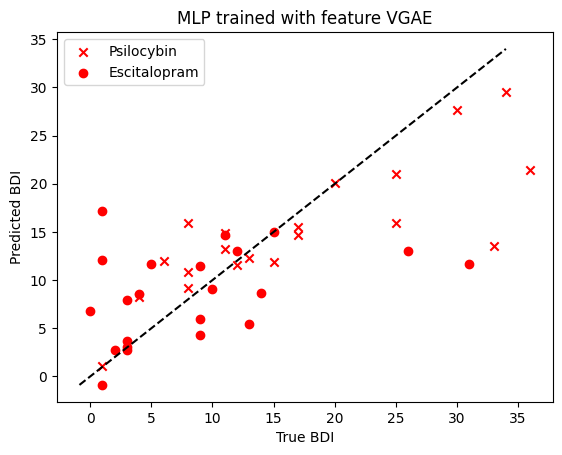

Average R-squared: 0.46682231626390164
Average MAE: 4.800151989360651


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error

r2_scores = []
mae_scores = []
r_scores = []

l1 = []
l2 = []

colors = ['red', 'blue', 'green', 'orange', 'purple']

for fold in best_set:
    l1.extend([t.item() for t in fold[0]])
    l2.extend([t.item() for t in fold[1]])

print(r2_score(l1, l2))
print(pearsonr(l1, l2))
print(mean_absolute_error(l1,l2))

print()

total_true = []
total_pred = []
total_drug = []
total_base = []

for i, (true, pred, base) in enumerate(best_set):
    true = [t.item() for t in true]
    pred = [p.item() for p in pred]
    drug = [d[0].item() for d in base]
    base = [d[1].item() for d in base]
    
    print(pred)
    
    total_true.extend(true)
    total_pred.extend(pred)
    total_drug.extend(drug)
    total_base.extend(base)
    # Calculate R-squared (Pearson correlation coefficient)
    r2 = r2_score(true, pred)
    r2_scores.append(r2)

    r_scores.append(pearsonr(true, pred))
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(true, pred)
    mae_scores.append(mae)
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)

        
min_val = min(min(true), min(pred))
max_val = max(max(true), max(pred))
plt.plot([min_val, max_val], [min_val, max_val], 'k--')
        
plt.xlabel('True BDI')
plt.ylabel('Predicted BDI')
plt.title('MLP trained with feature VGAE')
plt.legend(['Psilocybin', 'Escitalopram'])
plt.savefig('mlp_feature_vgae.png', bbox_inches='tight')
plt.show()

# Calculate average R-squared and MAE across all folds
avg_r2 = np.mean(r2_scores)
avg_mae = np.mean(mae_scores)

import csv
head = ['r2', 'pearson_r', 'pval']
with open('use_nf.csv', 'w', newline='') as f:
    writer = csv.writer(f)

    # Write the header
    writer.writerow(head)

    # Write the data rows
    for i in range(5):
        writer.writerow([r2_scores[i], r_scores[i][0], r_scores[i][1]])
        
# Specify the filename for the CSV file
filename = 'feature-vgae-full-val-resultss.csv'

# Create a list of rows with headers
rows = [['true_post_bdi', 'predicted_post_bdi', 'drug (1 for psilo)', 'base_bdi']]
for true, pred, drug, base in zip(total_true, total_pred, total_drug, total_base):
    rows.append([true, pred, drug, base])

# Write the rows to the CSV file
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)
        
print('Average R-squared:', avg_r2)
print('Average MAE:', avg_mae)